**Table of contents**<a id='toc0_'></a>    
- [Importation des données](#toc1_)    
- [Analyse RFM](#toc2_)    
  - [Délai](#toc2_1_)    
  - [Fréquence](#toc2_2_)    
  - [Dépense](#toc2_3_)    
  - [Fusion d'informations](#toc2_4_)    
  - [Valeures extrêmes](#toc2_5_)    
  - [KMean](#toc2_6_)    
    - [Scale data](#toc2_6_1_)    
  - [Normalisation des données](#toc2_7_)    
- [K-means](#toc3_)    
- [DBSCAN](#toc4_)    
    - [Calcul de la proximité des données entre elles en utilisant Nearest Neighbours](#toc4_1_1_)    
    - [Optimisation d'epsilone par evaluation des différentes valeures](#toc4_1_2_)    
- [TSNE](#toc5_)    
- [Sauvegarde des données](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Importation des données](#toc0_)

In [2]:
import pickle
input1 = open("./data/data.pickle", "rb")
df = pickle.load(input1)
input1.close()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sn
import datetime as dt
import warnings
import sklearn
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import homogeneity_score, make_scorer

# <a id='toc2_'></a>[Analyse RFM](#toc0_)
*Recency*: Délai. Fait référence au temps qui s'est écoulé depuis le dernier achat d'un client. Il s'agit d'un facteur important car les clients qui ont interagi avec une marque récemment sont plus susceptibles de répondre à une action marketing, ce qui rend leur identification très pertinente.


*Frequency*: Fréquence. Fait référence au nombre de fois qu'un client a réalisé un achat. Les clients qui ont réalisé plus d'un achat sont plus susceptibles d'acheter à nouveau.


*Monetary*: Dépense. Fait référence au montant que le client a dépensé sur une période de temps. Les clients qui ont dépensé des montants importants sont plus susceptibles de réaliser de futurs achats et ont une forte valeur commerciale.

## <a id='toc2_1_'></a>[Délai](#toc0_)

In [2]:
recency_df = df.groupby(['customer_unique_id'], as_index = False)['order_purchase_timestamp'].max()
current_date = df['order_purchase_timestamp'].max() + dt.timedelta(days = 1)
recency_df['recency'] = recency_df['order_purchase_timestamp'].apply(lambda x: (current_date - x).days)
recency_df.head()

,customer_unique_id,order_purchase_timestamp,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,112
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,115
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,537
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,321
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,288


## <a id='toc2_2_'></a>[Fréquence](#toc0_)

In [3]:
frequency_df = pd.DataFrame(df.groupby('customer_unique_id', as_index = False)["order_id"].count())
frequency_df.rename(columns = {"order_id": "frequency"}, inplace=True)
frequency_df.head()

,customer_unique_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


## <a id='toc2_3_'></a>[Dépense](#toc0_)

In [4]:
monetary_df = df.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
monetary_df.rename(columns={"payment_value":"monetary"}, inplace=True)
monetary_df.head()

,customer_unique_id,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


## <a id='toc2_4_'></a>[Fusion d'informations](#toc0_)

In [5]:
#Merge dataframes
rfm_df = recency_df.merge(frequency_df, on='customer_unique_id')
rfm_df = rfm_df.merge(monetary_df, on='customer_unique_id')
rfm_df.drop(columns='order_purchase_timestamp', inplace = True)
rfm_df.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19
2,0000f46a3911fa3c0805444483337064,537,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89


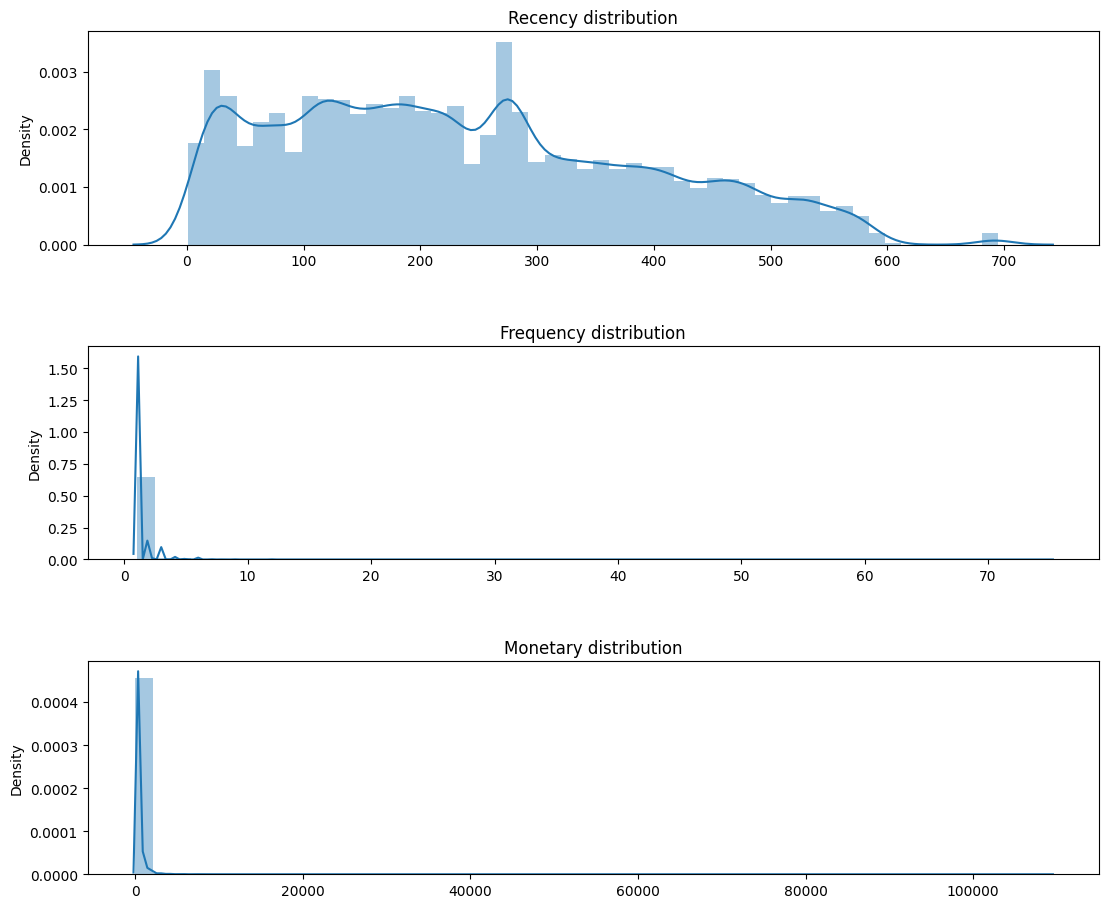

In [6]:
plt.figure(figsize=(12, 10))
warnings.simplefilter("ignore")
#Recency
plt.subplot(3, 1, 1)
sn.distplot(rfm_df['recency'])
plt.title('Recency distribution')
plt.xlabel(None)

#Frequency
plt.subplot(3, 1, 2)
sn.distplot(rfm_df['frequency'])
plt.title('Frequency distribution')
plt.xlabel(None)

#Monetary
plt.subplot(3, 1, 3)
sn.distplot(rfm_df['monetary'])
plt.title('Monetary distribution')
plt.xlabel(None)

plt.tight_layout(pad = 4)

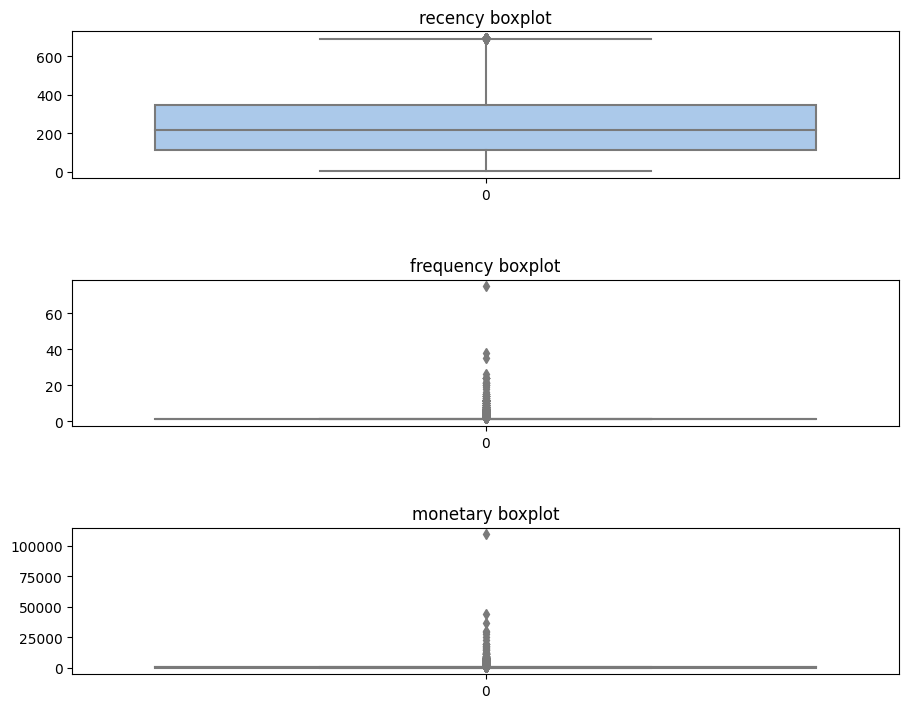

In [7]:
#Columns to examine
features = ['recency', 'frequency', 'monetary']

#Creating a boxplot for outlier detection
n = 1

plt.figure(figsize = (10, 8))

for feature in features:
    plt.subplot(3,1,n)
    sn.boxplot(rfm_df[feature], palette = 'pastel').set(xlabel = None)
    plt.title(f'{feature} boxplot')
    n = n + 1
    
plt.tight_layout(pad = 4)

## <a id='toc2_5_'></a>[Valeurs extrêmes](#toc0_)

In [8]:
def remove_outlier(input_df, colum_name):
    """remove_outlier _summary_ Detele extreme outliers

    Args:
        input_df (_type_): _description_ A pandas data frame
        colum_name (_type_): _description_ A column name of argument df

    Returns:
        _type_: _description_ A pandas data frame
    """
    q1 = input_df[colum_name].quantile(0.05)
    q3 = input_df[colum_name].quantile(0.95)
    iqr = q3-q1     
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    index_outliers = input_df.loc[(input_df[colum_name] < fence_low) |
                                  (input_df[colum_name] > fence_high)].index
    input_df = pd.DataFrame(input_df.drop(index_outliers.to_list(), axis=0, inplace=True))
    return input_df

for i in ["recency", "monetary"]:
    remove_outlier(rfm_df, i)

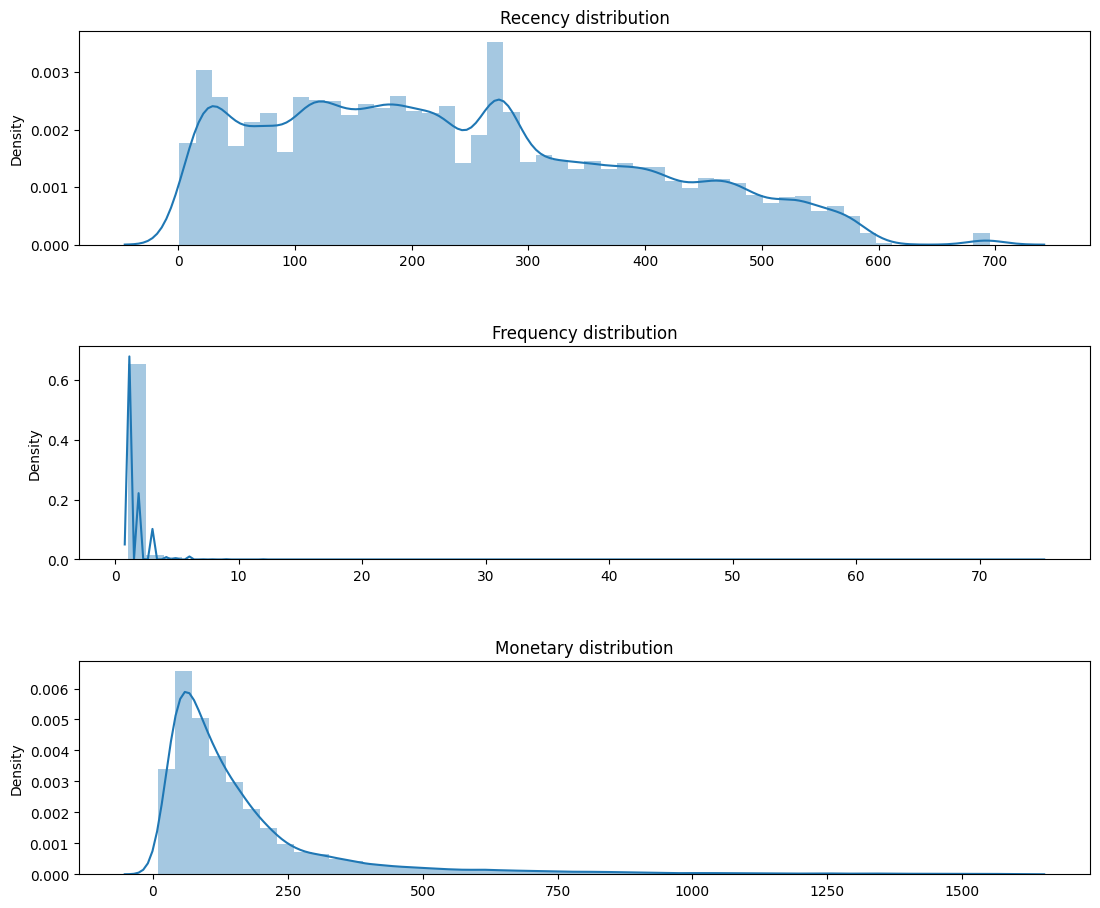

In [9]:
#Distribution plots after eliminating extreme outliers
plt.figure(figsize=(12, 10))

#Recency
plt.subplot(3, 1, 1)
sn.distplot(rfm_df['recency'])
plt.title('Recency distribution')
plt.xlabel(None)

#Frequency
plt.subplot(3, 1, 2)
sn.distplot(rfm_df['frequency'])
plt.title('Frequency distribution')
plt.xlabel(None)

#Monetary
plt.subplot(3, 1, 3)
sn.distplot(rfm_df['monetary'])
plt.title('Monetary distribution')
plt.xlabel(None)

plt.tight_layout(pad = 4)

## <a id='toc2_6_'></a>[KMean](#toc0_)
### <a id='toc2_6_1_'></a>[Scale data](#toc0_)

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_df.iloc[:,1:])
tmp = scaler.transform(rfm_df.iloc[:,1:])

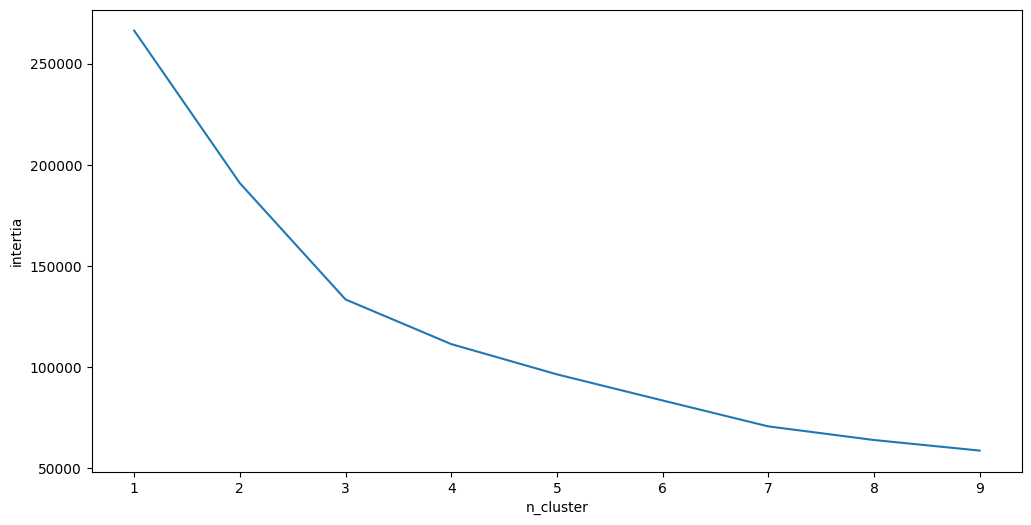

In [11]:
from sklearn.cluster import KMeans
# Une liste vide pour enregistrer les inerties :  
intertia_list = [ ]

# Notre liste de nombres de clusters : 
k_list = range(1, 10)

# Pour chaque nombre de clusters : 
for k in k_list : 
    
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k)
    
    # On entraine
    kmeans.fit(tmp)
    
    # On enregistre l'inertie obtenue : 
    intertia_list.append(kmeans.inertia_)
    
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")

ax = plt.plot(k_list, intertia_list)

In [12]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tmp)
rfm_df["Kmean"] = kmeans.labels_

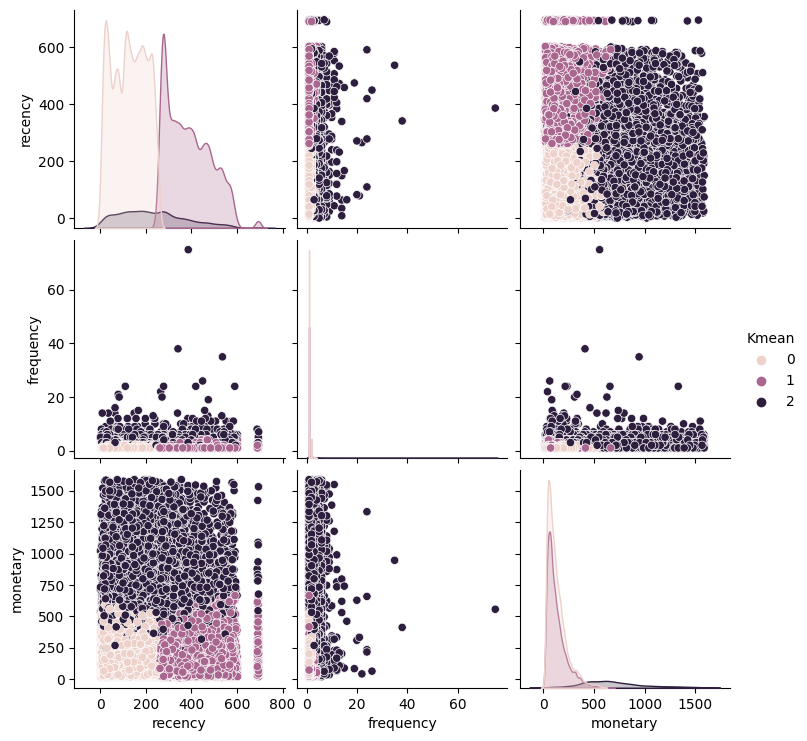

In [13]:
sn.pairplot(rfm_df.iloc[:,1:], hue="Kmean")

Les groupes peuvent être décrits comme :

    Groupe 0: Dépenses élevées (monetary) à fréquence d'achat moyenne (frequency), indépendamment du délai depuis la dernière commande (recency) = +++

    Groupe 1: Dépenses faibles (monetary) à fréquence d'achat faible (frequency), avec un délai depuis la dernière commande élevé (recency) = +

    Groupe 2: Dépenses moyennes (monetary) à fréquence d'achat élevée (frequency), indépendamment du délai depuis la dernière commande (recency) = ++

On peut voir que ni la fréquence ni le délai ne discrimine énormement les clients puisque la plupart des clients font un seul achat. La dépense étant déjà disponible dans le tableau à travers les dépenses unitaires des acheteurs, ces trois métriques vont être écartées.

In [3]:

X = df.drop(['seller_geolocation_lng', 'seller_geolocation_lat', "geolocation_zip_code_prefix",
             "payment_value", "order_id", "seller_id", "customer_unique_id", 'seller_geolocation_lat',
             'seller_geolocation_lng', 'order_purchase_timestamp', 'geolocation_zip_code_prefix'], axis = 1)

## <a id='toc2_7_'></a>[Normalisation des données](#toc0_)

In [4]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# <a id='toc3_'></a>[K-means](#toc0_)

For n_clusters = 2 The average silhouette_score is : 0.03656743484755776 , with a Davies Bouldin index of : 5.154648122332947 , an intertia of : 133484.71355776186 and an average of cluster size of: 55506.5
For n_clusters = 3 The average silhouette_score is : 0.07461868998946773 , with a Davies Bouldin index of : 3.5209253593333076 , an intertia of : 133484.71355776186 and an average of cluster size of: 37004.333333333336
For n_clusters = 4 The average silhouette_score is : 0.0794853652237885 , with a Davies Bouldin index of : 2.8269417705426236 , an intertia of : 133484.71355776186 and an average of cluster size of: 27753.25
For n_clusters = 5 The average silhouette_score is : 0.0926009118192597 , with a Davies Bouldin index of : 2.5666838187324066 , an intertia of : 133484.71355776186 and an average of cluster size of: 22202.6
For n_clusters = 6 The average silhouette_score is : 0.08403876011713518 , with a Davies Bouldin index of : 2.573213282800426 , an intertia of : 133484.7135577

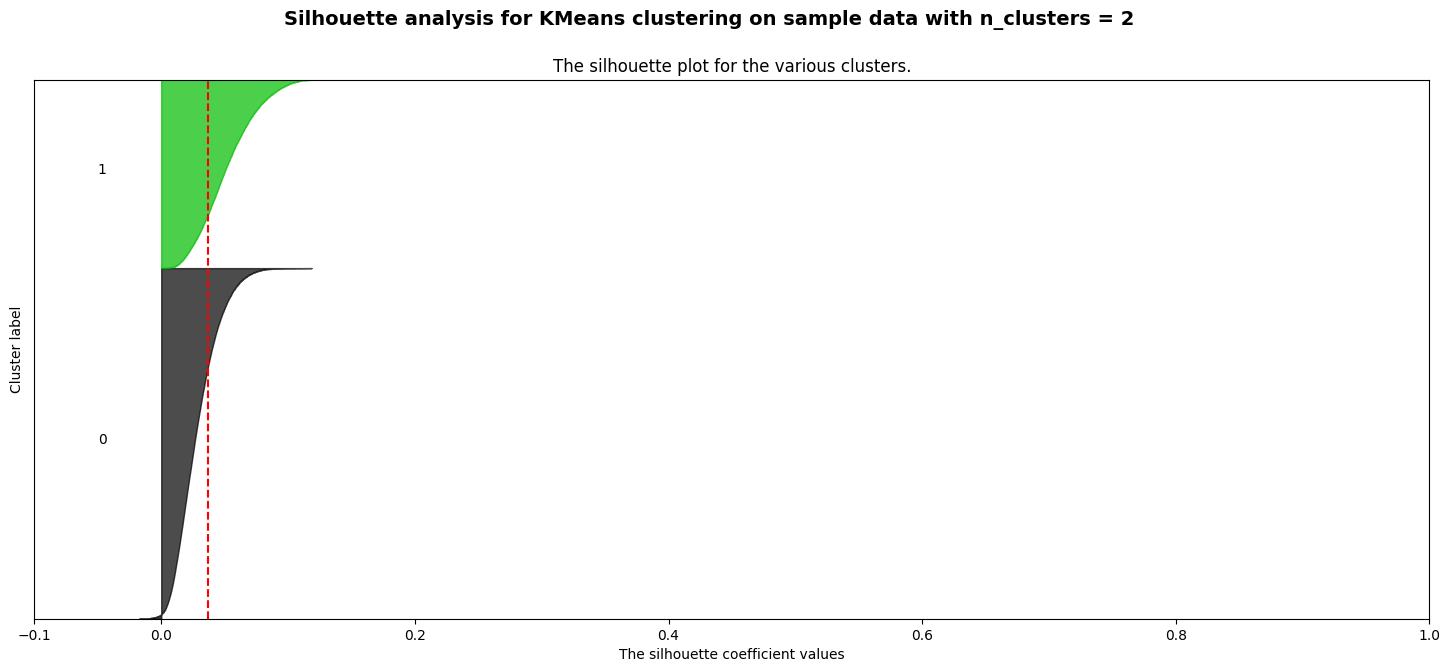

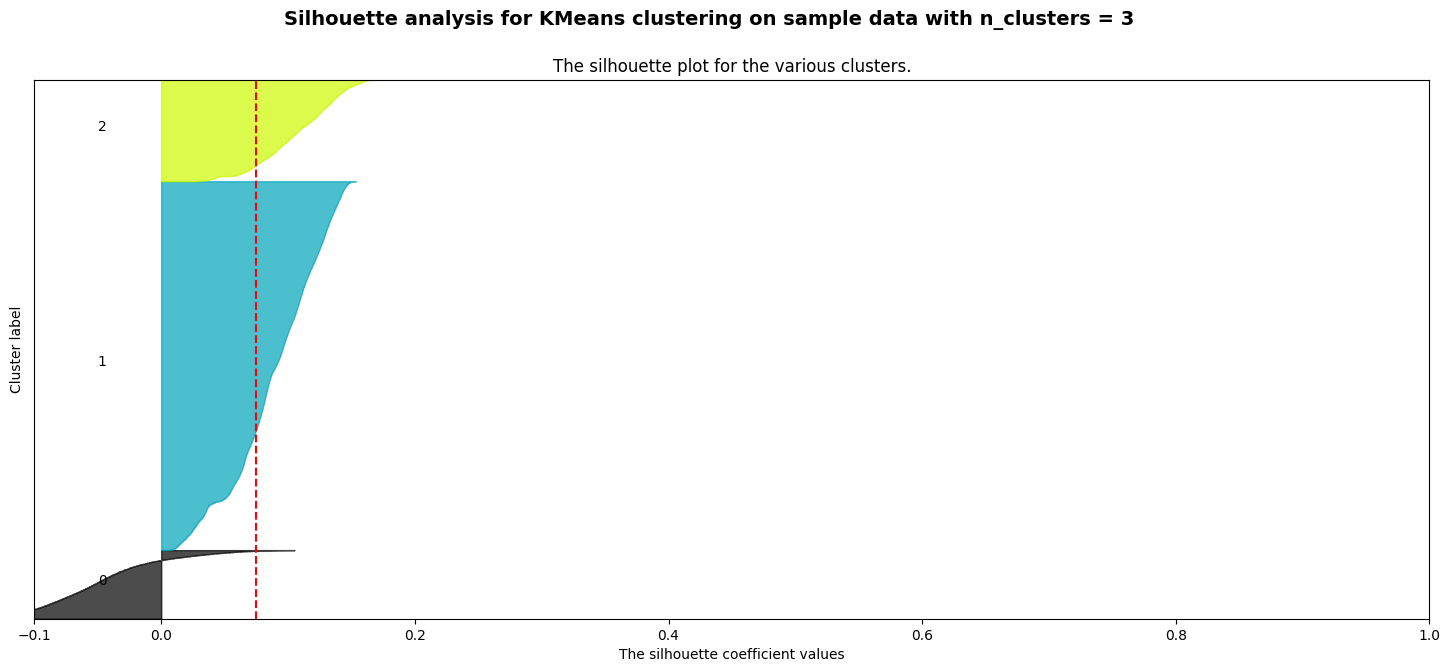

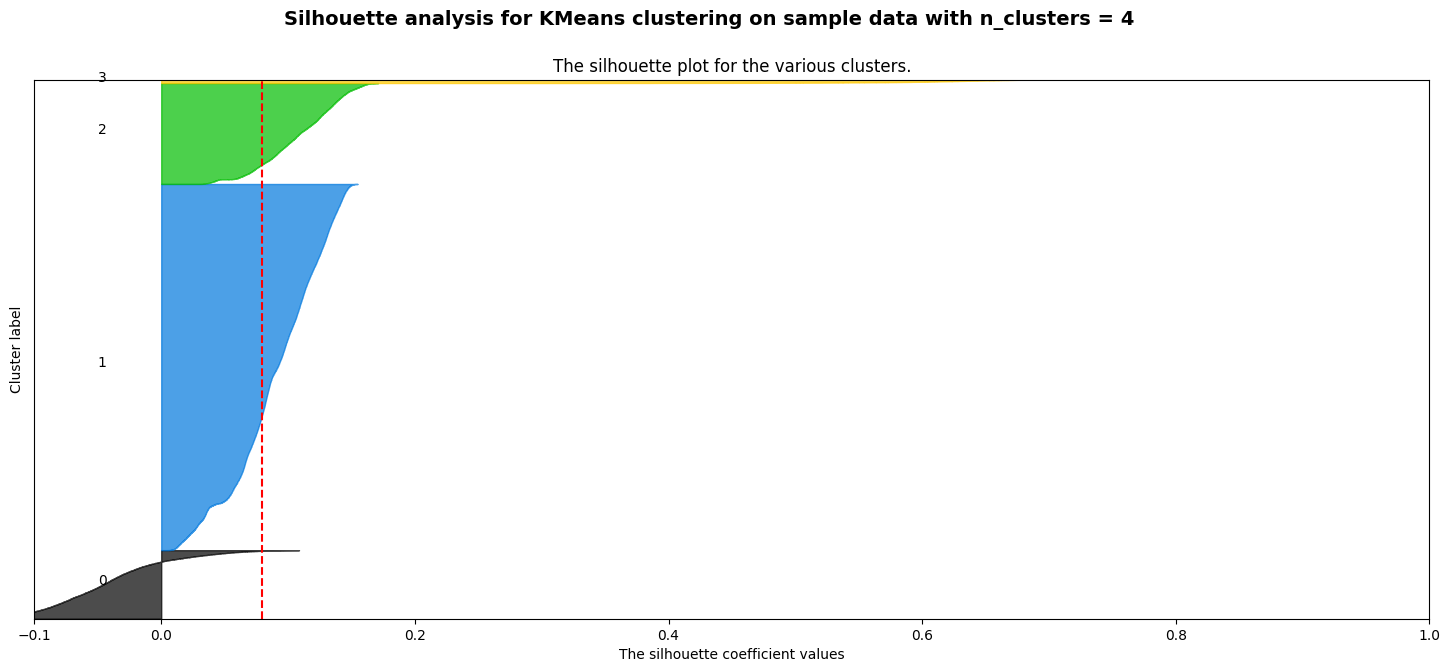

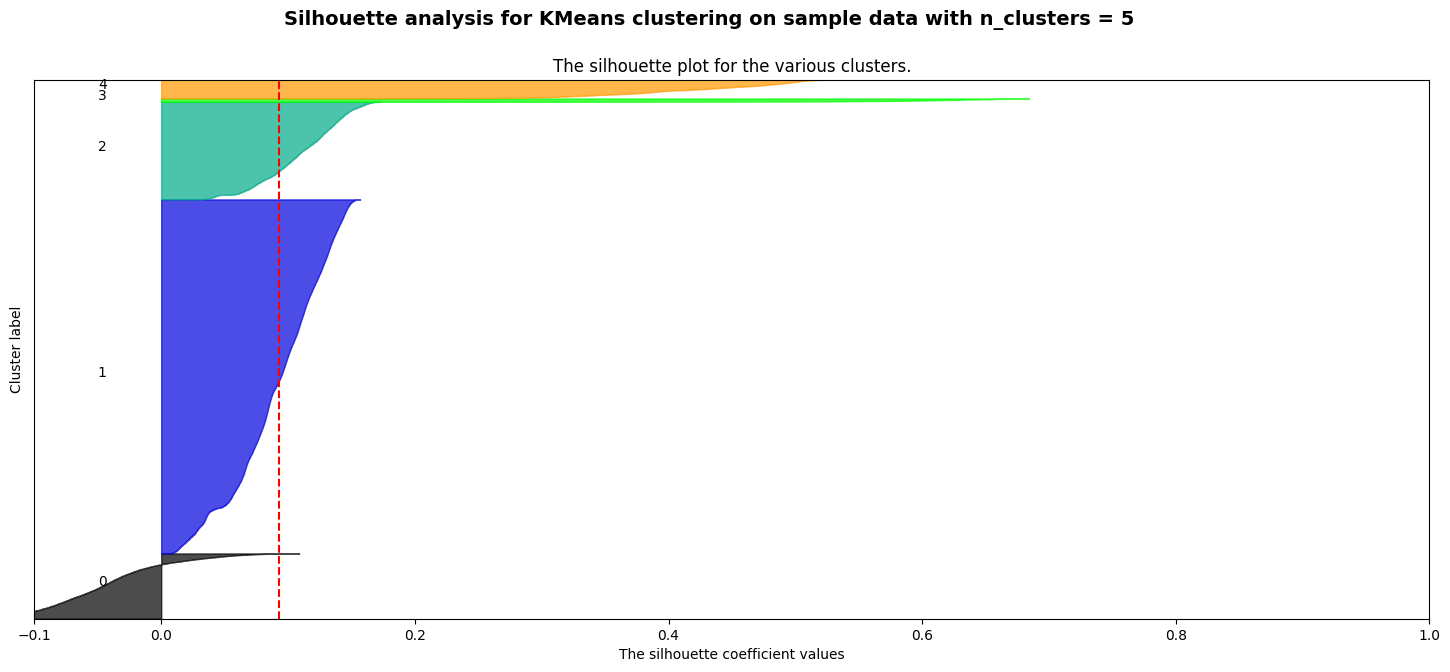

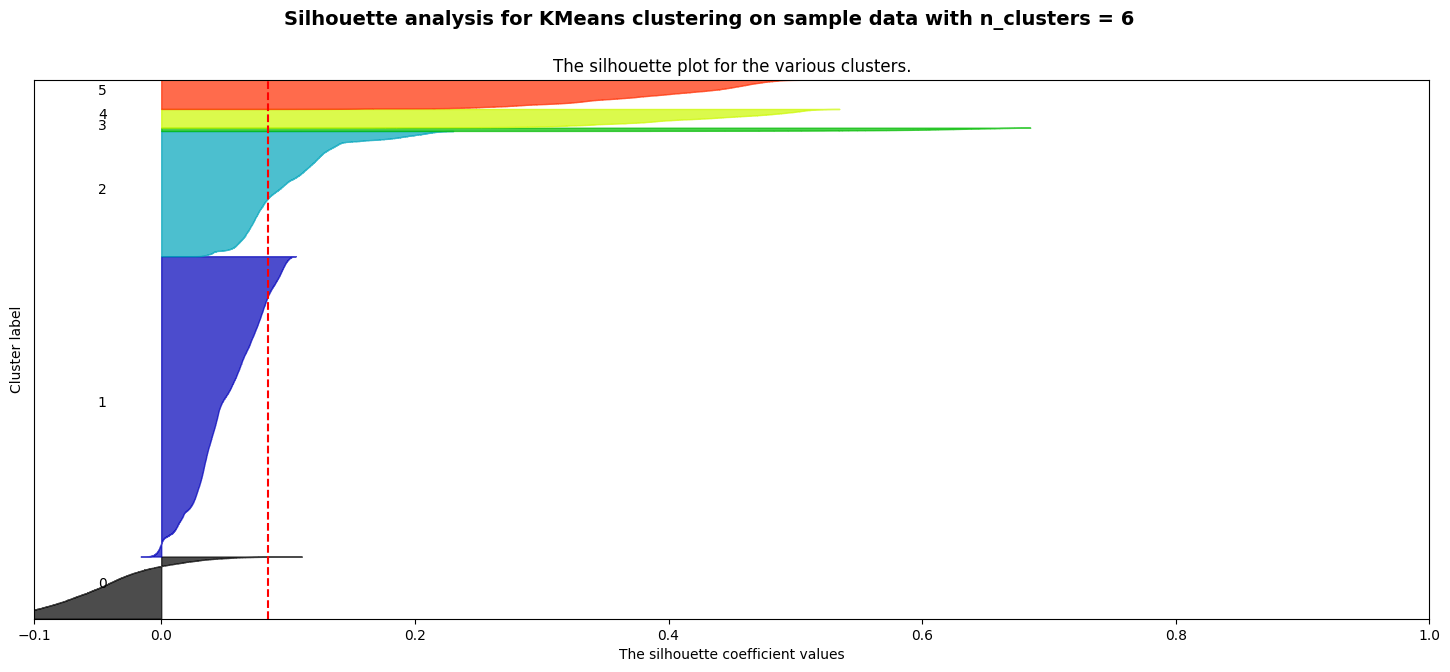

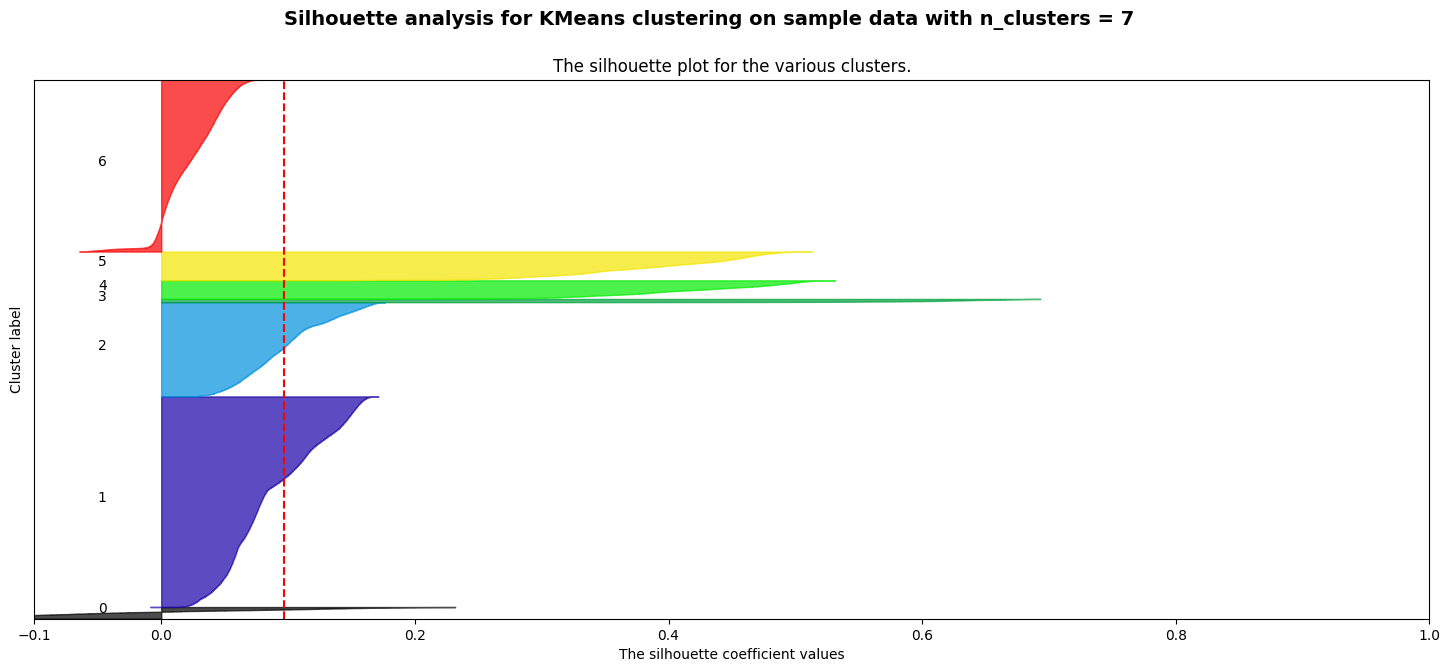

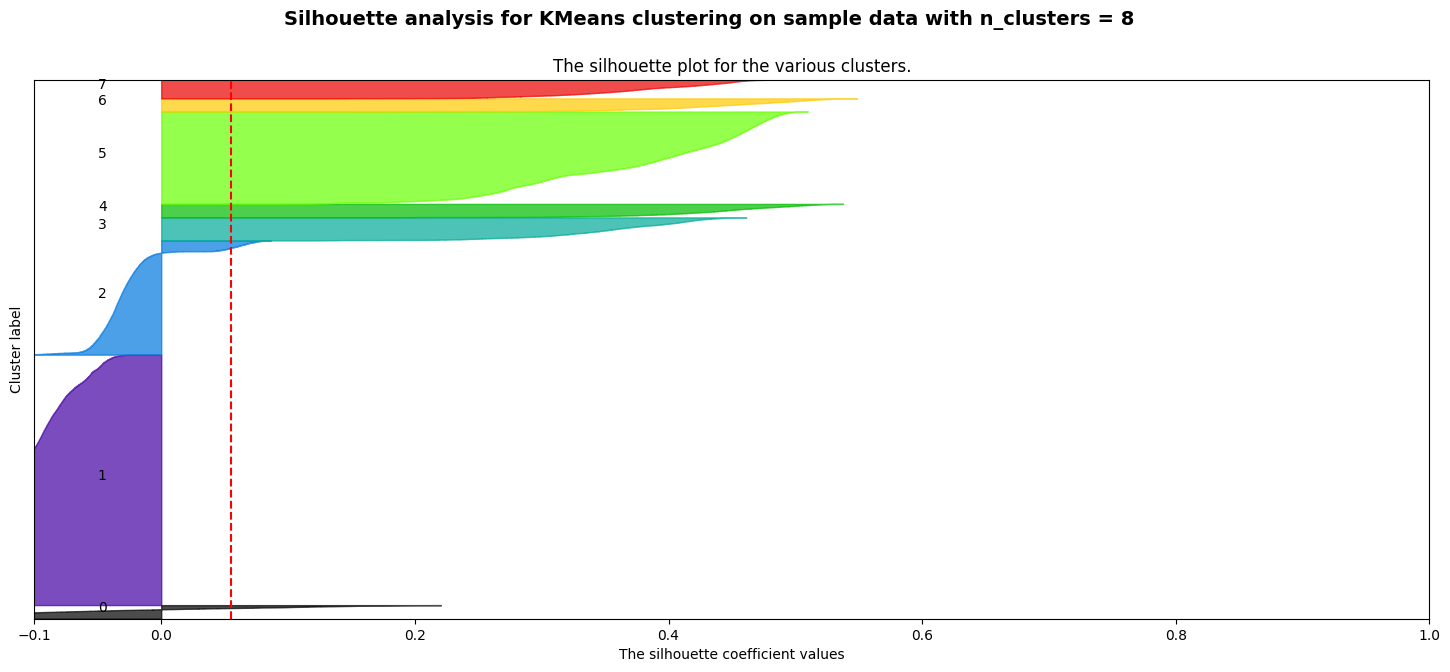

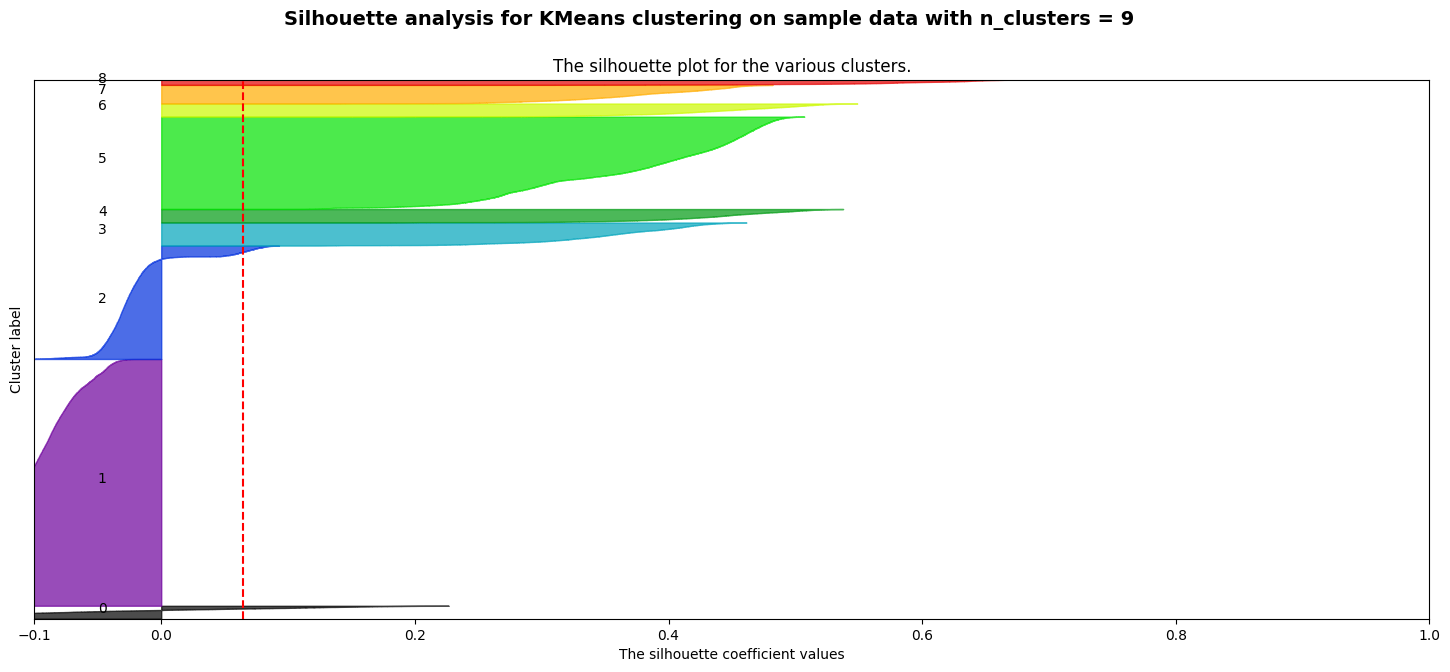

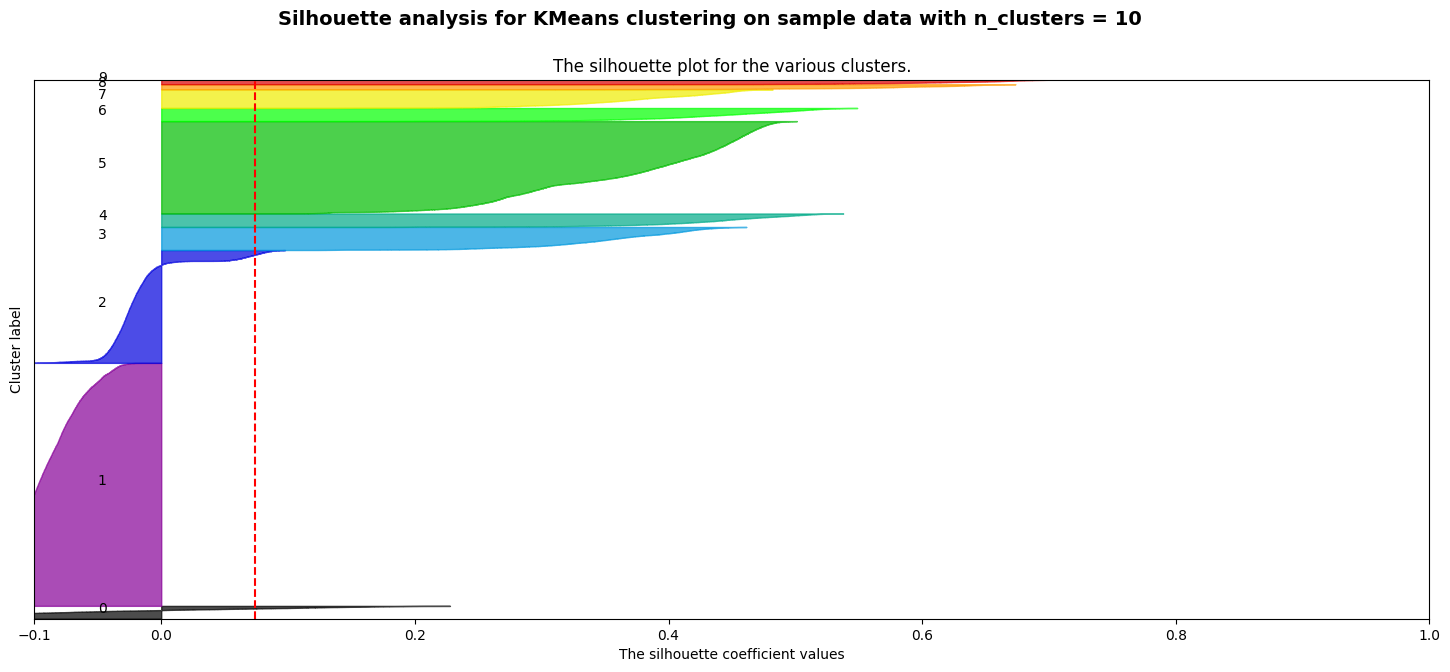

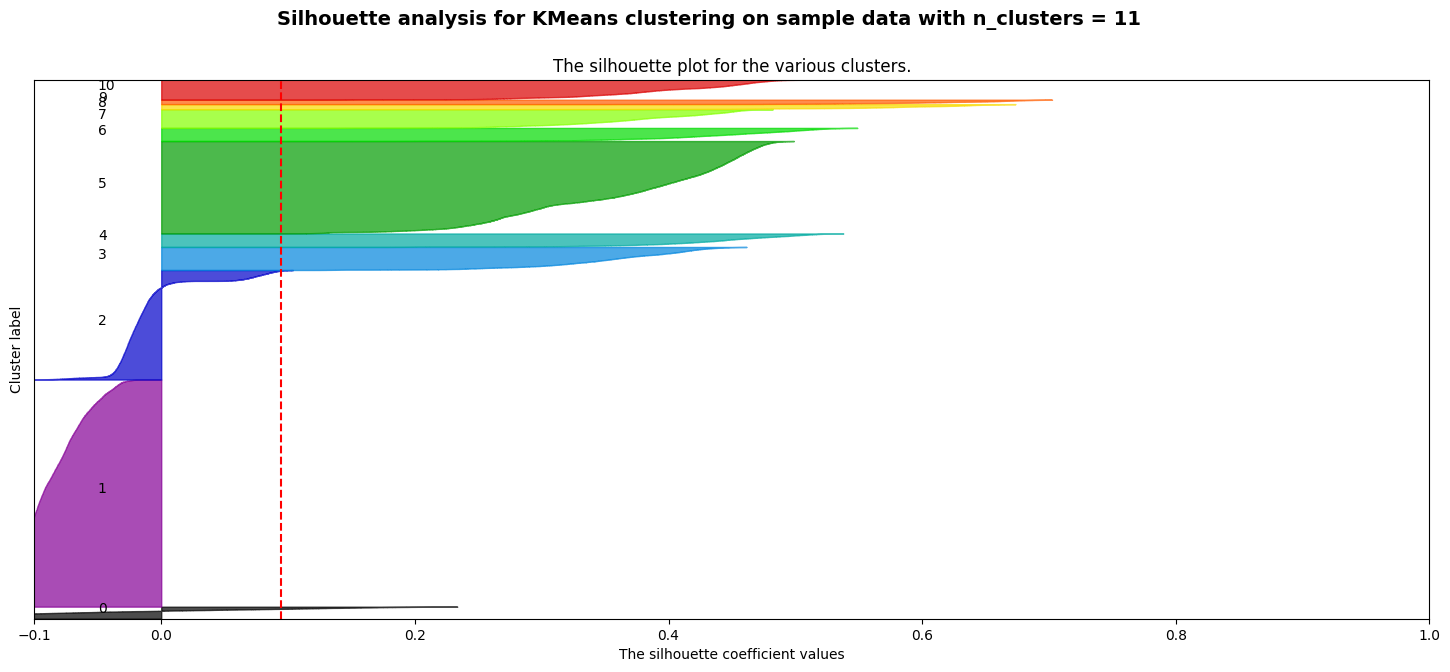

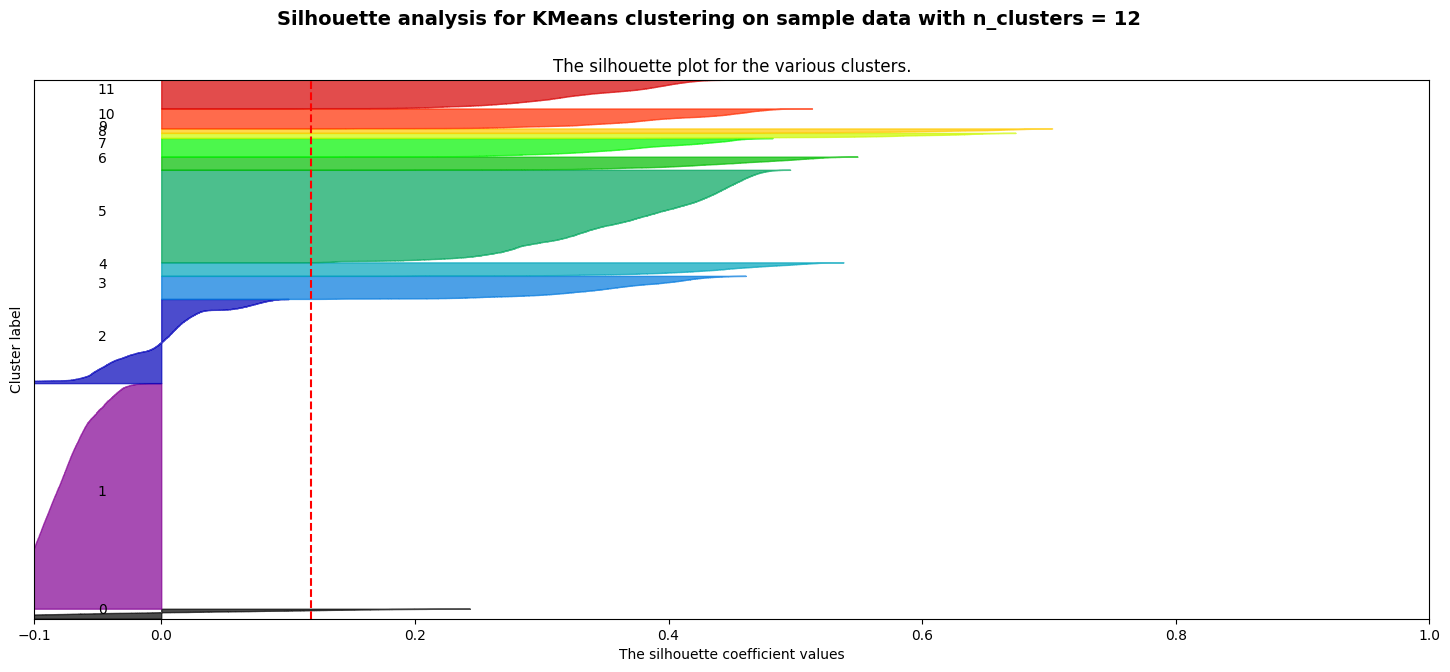

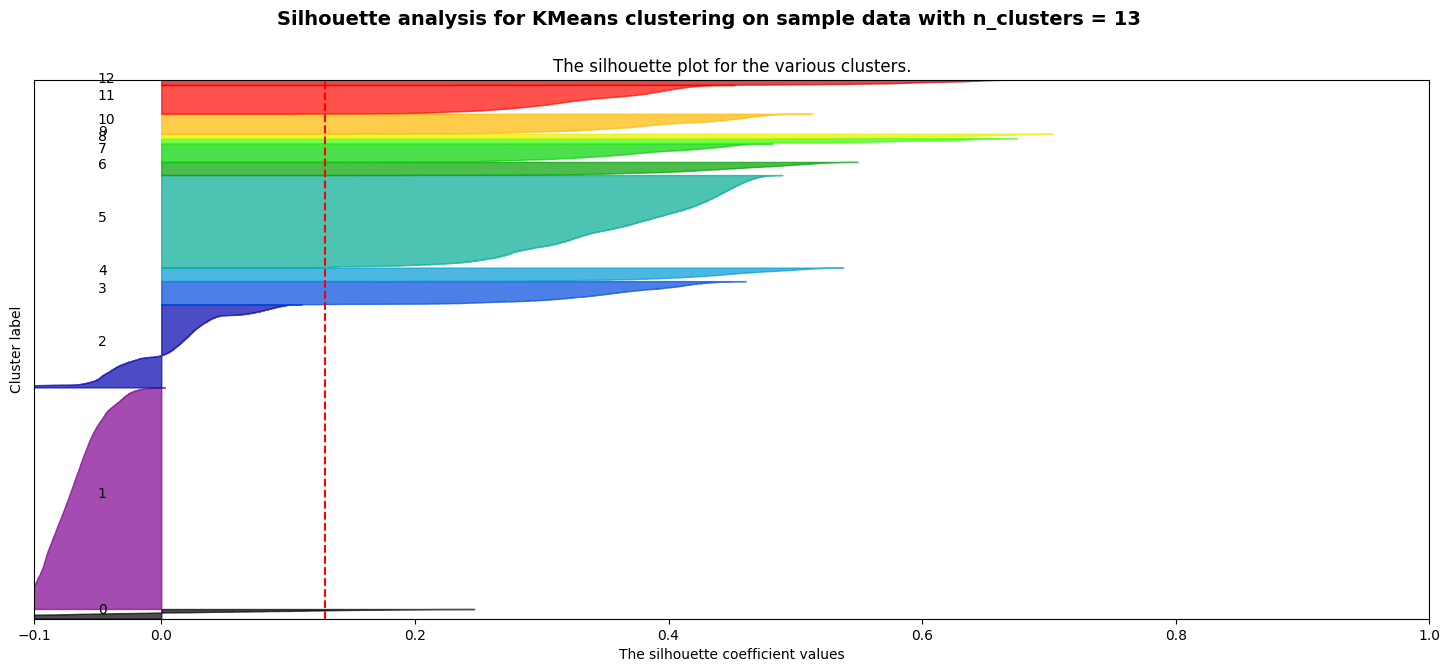

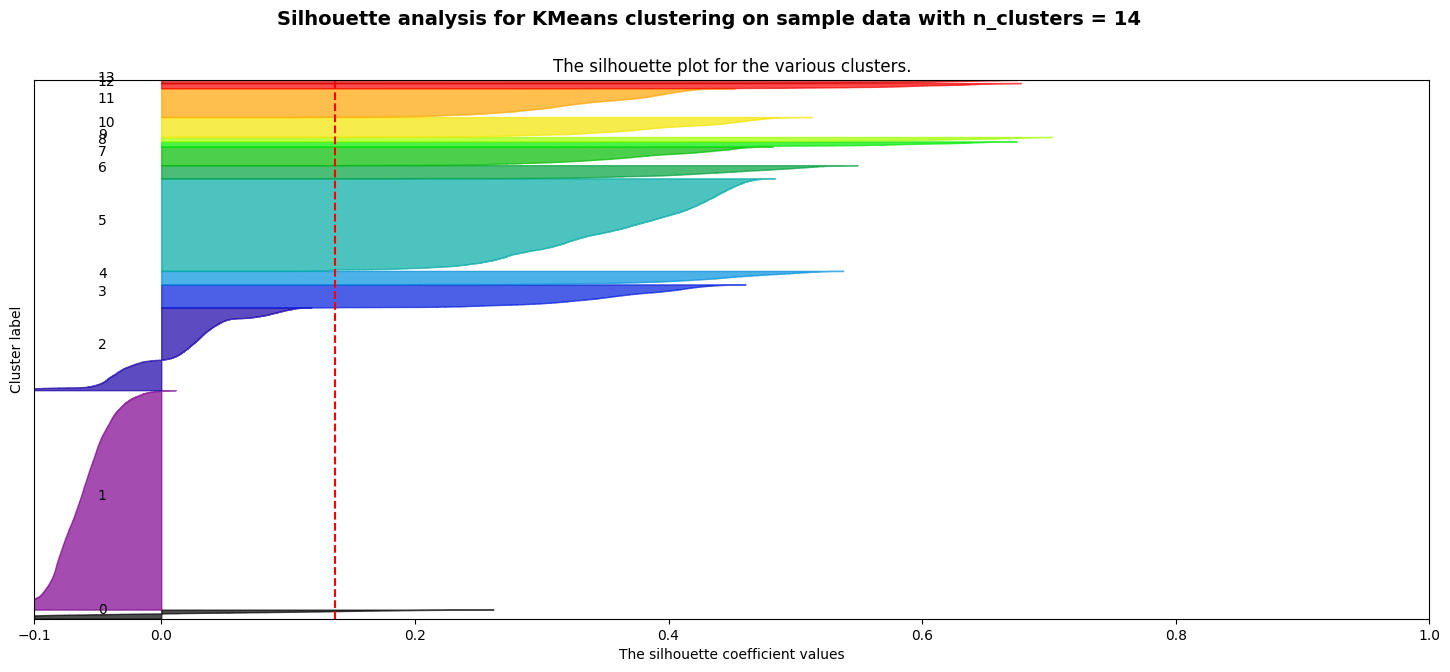

In [16]:
range_n_clusters = range(2, 15)
intertia_list = [ ]
silhouette_list = []
david_list = []
ClustersSizes_list = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    
    # Davies Bouldin Index
    david = sklearn.metrics.davies_bouldin_score(X = X, labels= cluster_labels)
    
    # Clusters sizes
    unique, counts = np.unique(cluster_labels, return_counts=True)
    
    # Extracting informations
    silhouette_list.append(silhouette_avg) 
    intertia_list.append(kmeans.inertia_)
    david_list.append(david)
    ClustersSizes_list.append(counts.mean())
    # silhouette_score Plot
    
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        ', with a Davies Bouldin index of :',
        david,
        ', an intertia of :',
        kmeans.inertia_,
        'and an average of cluster size of:',
        counts.mean()
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    colors = []
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        
        from matplotlib.colors import to_hex
        colors.append(to_hex(color))
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #sn.set_palette(sn.color_palette(colors))
    
    #ax2 = sn.barplot(x = unique, y = counts, hue = unique)
    ## Labeling the clusters
    #centers = clusterer.cluster_centers_
    #
    #tsne = TSNE(n_components=n_clusters)
    #T = tsne.fit_transform(X)

    #plt.title('Représentation du jeu de données via T-SNE')
    #ax2 = sn.scatterplot(x = T[:,0], y = T[:,1], hue = clusterer.labels_)
    
    # 2nd Plot showing the actual clusters formed
    #colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    #ax2.scatter(
    #    X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    #)
    
    ## Draw white circles at cluster centers
    #ax2.scatter(
    #    centers[:, 0],
    #    centers[:, 1],
    #    marker="o",
    #    c="white",
    #    alpha=1,
    #    s=200,
    #    edgecolor="k",
    #)
    
    #for i, c in enumerate(centers):
    #    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    #ax2.set_title("The visualization of the clustered data.")
    #ax2.set_xlabel("Feature space for the 1st feature")
    #ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

# <a id='toc4_'></a>[DBSCAN](#toc0_)

### <a id='toc4_1_1_'></a>[Calcul de la proximité des données entre elles en utilisant Nearest Neighbours](#toc0_)

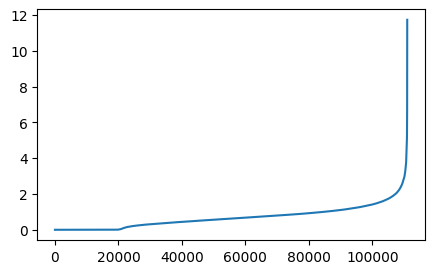

In [5]:
from sklearn.neighbors import NearestNeighbors # importing the library
neighb = NearestNeighbors(n_neighbors=5) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(X) # fitting the data to the object
distances,indices=nbrs.kneighbors(X) # finding the nearest neighbours

# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

In [24]:
db = DBSCAN(eps=4, min_samples=5, n_jobs= -1).fit(X)
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 87
Estimated number of noise points: 544


<AxesSubplot: >

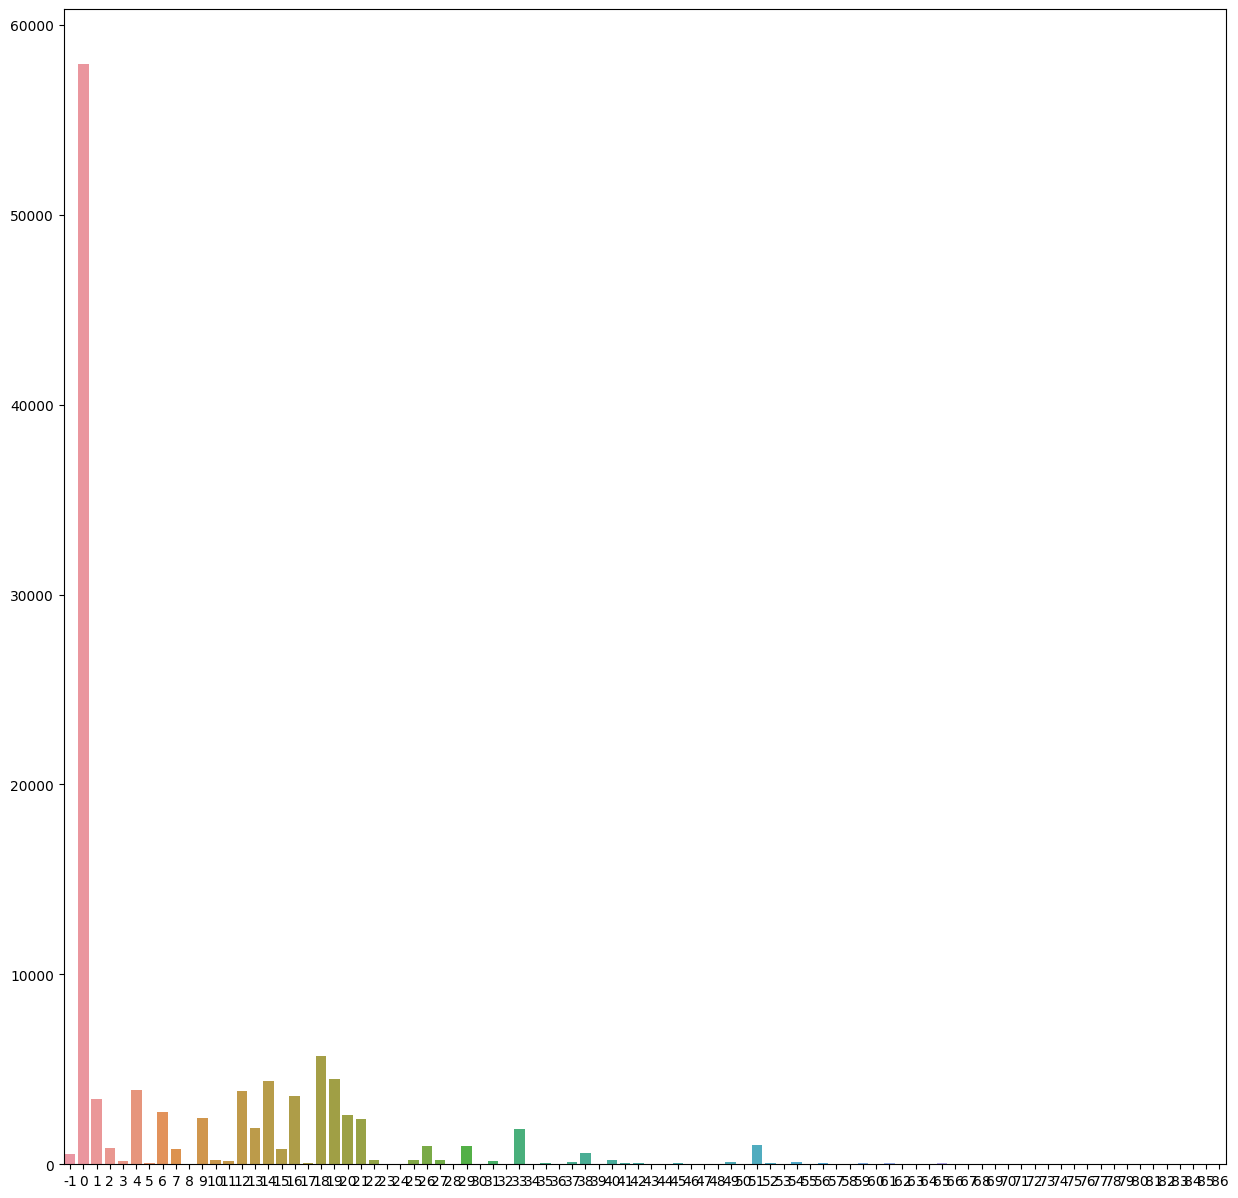

In [25]:
unique, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(15,15))
sn.barplot(x = unique, y = counts)

### <a id='toc4_1_2_'></a>[Optimisation d'epsilone par evaluation des différentes valeurs](#toc0_)
Trop de mémoires requises (>32Go) impossible de le réaliser.

In [6]:
def score_func(estimator, X, **kwargs):
        """score_func _summary_ Compute silhouette_score

        Args:
            estimator (_type_): _description_ A DBSCAN object
            X (_type_): _description_ A numpy array on which to use DBSCAN to compute the silhouette_score

        Returns:
            _type_: _description_ silhouette_score
        """
        estimator.fit(X)
        cluster_labels = estimator.labels_
        return silhouette_score(X, cluster_labels)

scorer = metrics.make_scorer(score_func)


cv = [(slice(None), slice(None))]
param_dict = {
            'eps': [0.01, 0.1, 0.4, 0.8, 1, 4],
            'min_samples': [4, 8]
}

gs = GridSearchCV(estimator=DBSCAN(), param_grid=param_dict, cv=cv, scoring=scorer)
gs.fit(X) 
labels = gs.best_estimator_.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


c:\Users\SSosa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\SSosa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\Users\SSosa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\SSosa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_t

Estimated number of clusters: 1001
Estimated number of noise points: 105681


<AxesSubplot: >

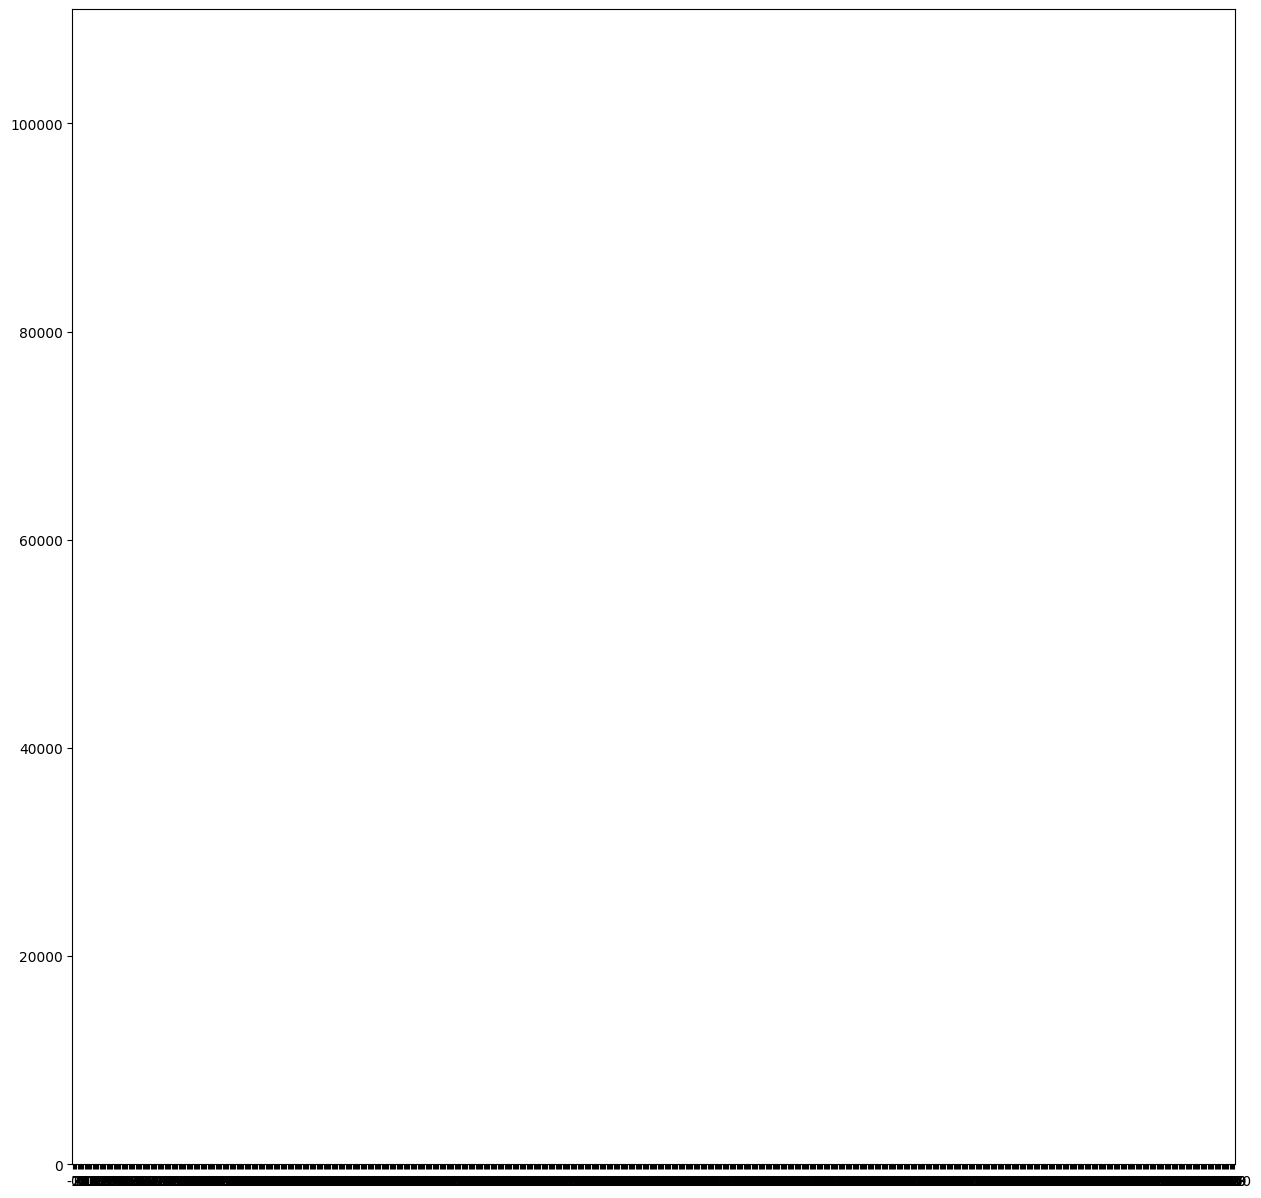

In [7]:
unique, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(15,15))
sn.barplot(x = unique, y = counts)

DBSCAN Trouve 1001. On va donc privilégier Kmeans.

# <a id='toc5_'></a>[TSNE](#toc0_)

In [8]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)


c:\Users\SSosa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=7)

<AxesSubplot: title={'center': 'Représentation du jeu de données via T-SNE'}>

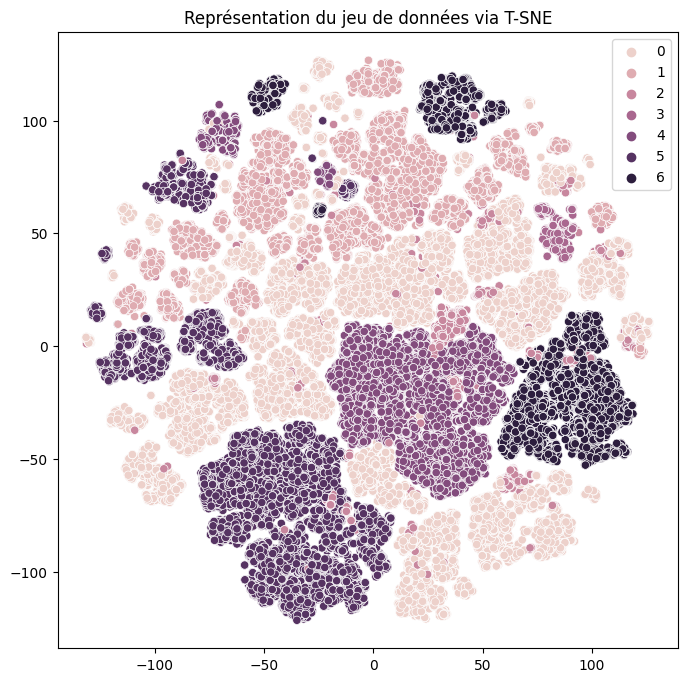

In [10]:
tsne = TSNE(n_components=2)
T = tsne.fit_transform(X)
plt.figure(figsize=(8,8))
plt.title('Représentation du jeu de données via T-SNE')
sn.scatterplot(x = T[:,0], y = T[:,1], hue = kmeans.labels_)

<AxesSubplot: >

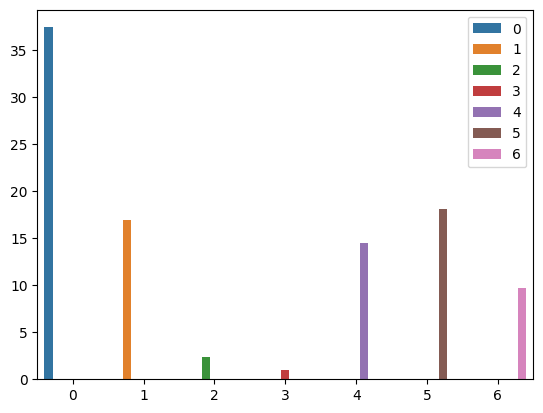

In [11]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
percentages =  counts * 100 / len(kmeans.labels_)
sn.barplot(x = unique, y = percentages, hue = unique)

# <a id='toc6_'></a>[Sauvegarde des données](#toc0_)

In [12]:
import pickle
save = open("kmean.pickle", "wb")
pickle.dump(kmeans, save)
save.close()

save = open("df.pickle", "wb")
pickle.dump(df, save)
save.close()